In [16]:
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.core.display import clear_output
from IPython.display import Image  
from math import sqrt
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pprint import pprint
from pylab import rcParams
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from subprocess import call
from termcolor import colored
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 5

## Data load

In [17]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
df = pd.read_csv(url,index_col=0)
df.head(5)

,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
2020-01-23,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
2020-01-24,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
2020-01-25,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
2020-01-26,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00


In [18]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 18834 entries, 2020-01-22 to 2020-04-03
Data columns (total 7 columns):
Country/Region    18834 non-null object
Province/State    5840 non-null object
Lat               18834 non-null float64
Long              18834 non-null float64
Confirmed         18761 non-null float64
Recovered         17812 non-null float64
Deaths            18761 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


In [19]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(18834, 7)

In [20]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [21]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [22]:
df.head()

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global
Date,,,,,,,,,
2020-01-22,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,Afghanistan,1
2020-01-23,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,Afghanistan,2
2020-01-24,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,Afghanistan,3
2020-01-25,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,Afghanistan,4
2020-01-26,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,Afghanistan,5


In [23]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [24]:
len(df['Province_and_country'].unique())

258

In [25]:
len(df['Country'].unique())

181

In [26]:
len(df['Province'].unique())

81

In [27]:
df.describe()

,Lat,Long,Confirmed,Recovered,Deaths,Days_since_outbreak_global
count,18834.00,18834.00,18761.00,17812.00,18761.00,18834.00
mean,21.87,22.44,727.36,208.68,31.59,37.00
std,24.50,71.38,6696.35,2544.62,395.10,21.07
min,-41.45,-135.00,0.00,0.00,0.00,1.00
25%,7.95,-23.04,0.00,0.00,0.00,19.00
50%,23.69,20.92,0.00,0.00,0.00,37.00
75%,41.30,84.25,48.00,2.00,0.00,55.00
max,71.71,178.06,275586.00,63612.00,14681.00,73.00


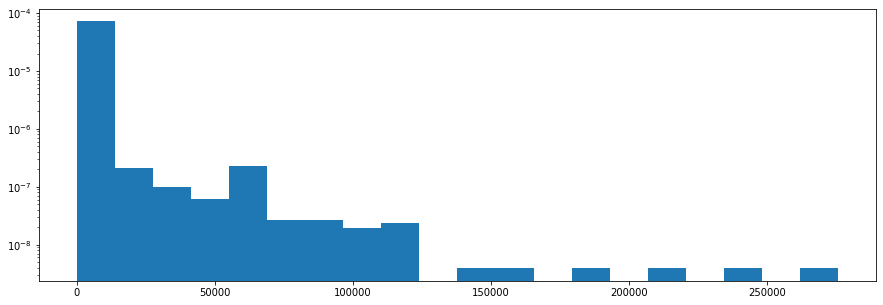

In [28]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

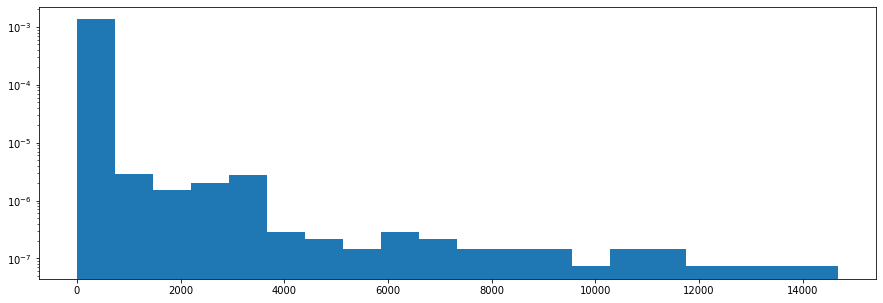

In [29]:
plt.hist(df['Deaths'], density=True, bins=20) 
plt.yscale('log')

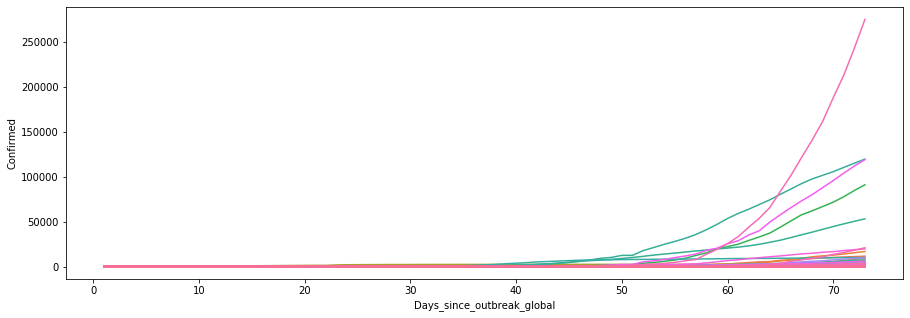

In [30]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

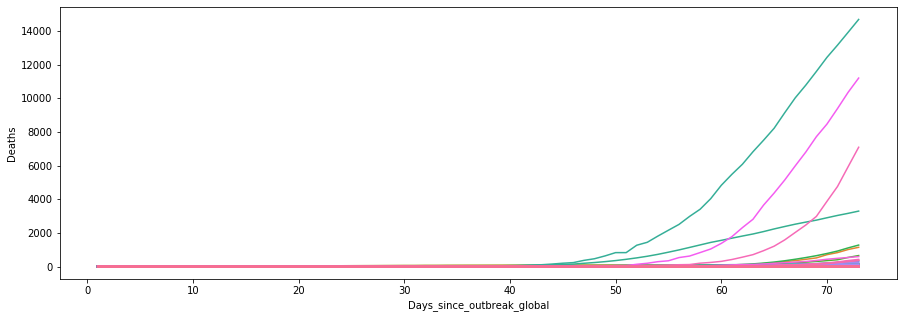

In [31]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Deaths", ci=None)
ax.legend_.remove()

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     64     65     66     67     68     69  \
Country                     ...                                             
Afghanistan                 ...  84.00  94.00 110.00 110.00 120.00 170.00   
Albania                     ... 146.00 174.00 186.00 197.00 212.00 223.00   
Algeria                     ... 302.00 367.00 409.00 454.00 511.00 584.00   
Andorra                     ... 188.00 224.00 267.00 3

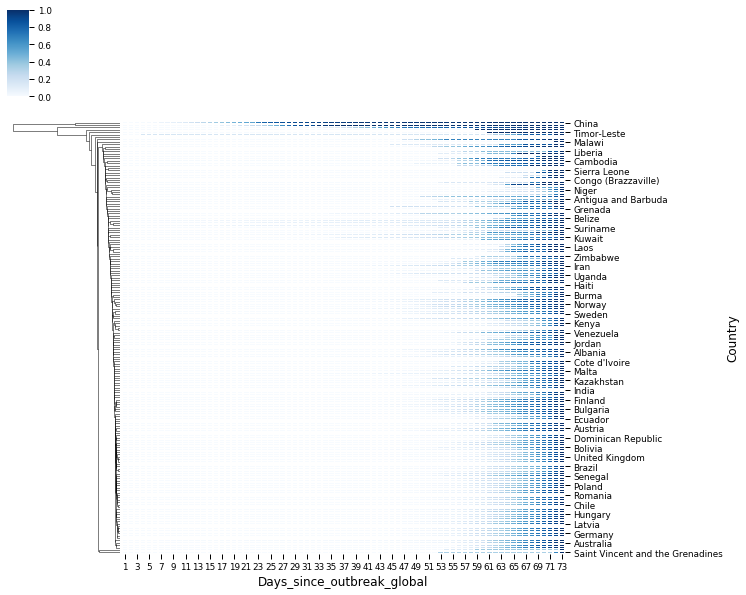

<Figure size 1800x576 with 0 Axes>

In [32]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [33]:
# function for getting the iso code through fuzzy search
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_2

# manually change name of some countries
df.loc[df['Country'] == 'Korea, South', 'Country'] = 'Korea, Republic of'
df.loc[df['Country'] == 'Taiwan*', 'Country'] = 'Taiwan'
df.loc[df['Country'] == 'Burma', 'Country'] = 'Myanmar'
df.loc[df['Country'] == 'Holy See', 'Country'] = 'Italy'
df.loc[df['Country'] == 'Laos', 'Country'] = "Lao"
df.loc[df['Country'] == "Congo (Kinshasa)", 'Country'] = "Congo"
df.loc[df['Country'] == "Congo (Brazzaville)", 'Country'] = "Congo"
df.loc[df['Country'] == "West Bank and Gaza", 'Country'] = "Palestine"

# create iso mapping for countries in df
iso_map = {country: do_fuzzy_search(country) for country in df['Country'].unique()}
# apply the mapping to df
df['iso'] = df['Country'].map(iso_map)

In [34]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Congo", 'Continent'] = "AF"
df.loc[df['Country'] == 'Timor-Leste', 'Continent'] = 'AS'
df.loc[df['Country'] == 'Diamond Princess', 'Continent'] = 'Diamond Princess'

df['Continent'] = df['Continent'].map({'Diamond Princess':'Diamond Princess','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global     1      2      3       4       5       6   \
Continent                                                                 
Africa                       0.00   0.00   0.00    0.00    0.00    0.00   
Asia                       554.00 653.00 937.00 1429.00 2105.00 2912.00   
Diamond Princess             0.00   0.00   0.00    0.00    0.00    0.00   
Europe                       0.00   0.00   2.00    3.00    3.00    4.00   
North America                1.00   1.00   2.00    2.00    6.00    6.00   

Days_since_outbreak_global      7       8       9       10  ...        64  \
Continent                                                   ...             
Africa                        0.00    0.00    0.00    0.00  ...   2773.00   
Asia                       5558.00 6143.00 8208.00 9889.00  ... 135417.00   
Diamond Princess              0.00    0.00    0.00    0.00  ...    712.00   
Europe                        8.00   10.00   10.00   18.00  ... 248874.00   
North Americ

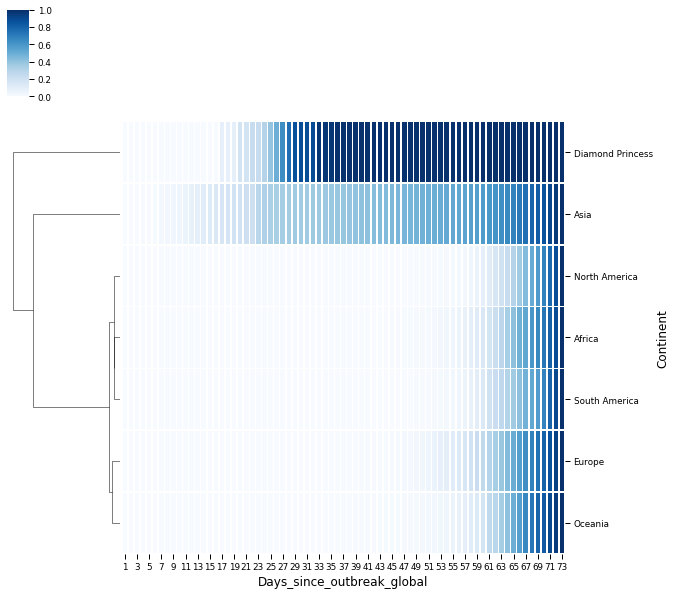

<Figure size 1800x576 with 0 Axes>

In [35]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     64     65     66     67     68     69  \
Country                     ...                                             
Afghanistan                 ...  84.00  94.00 110.00 110.00 120.00 170.00   
Armenia                     ... 265.00 290.00 329.00 407.00 424.00 482.00   
Azerbaijan                  ...  93.00 122.00 165.00 182.00 209.00 273.00   
Bahrain                     ... 419.00 458.00 466.00 4

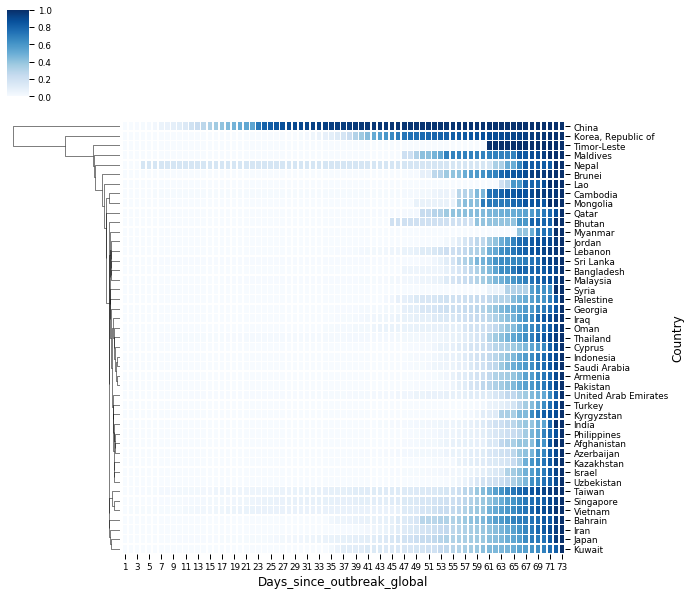

<Figure size 1800x576 with 0 Axes>

In [36]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      64      65      66      67       68  \
Country                     ...                                            
Albania                     ...  146.00  174.00  186.00  197.00   212.00   
Andorra                     ...  188.00  224.00  267.00  308.00   334.00   
Austria                     ... 5588.00 6909.00 7657.00 8271.00  8788.00   
Belarus                     ...   86.00   86.00   94.00   9

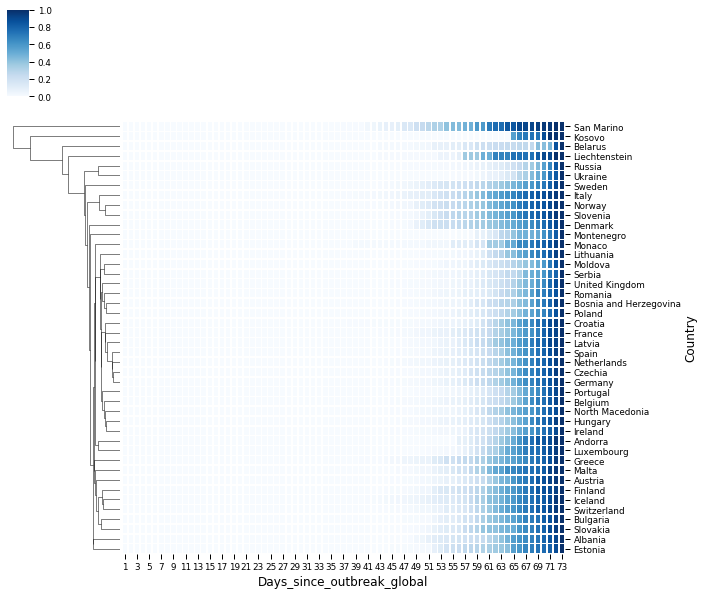

<Figure size 1800x576 with 0 Axes>

In [37]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     64     65     66     67     68     69  \
Country                     ...                                             
Algeria                     ... 302.00 367.00 409.00 454.00 511.00 584.00   
Angola                      ...   3.00   4.00   4.00   5.00   7.00   7.00   
Benin                       ...   6.00   6.00   6.00   6.00   6.00   6.00   
Botswana                    ...   0.00   0.00   0.00  

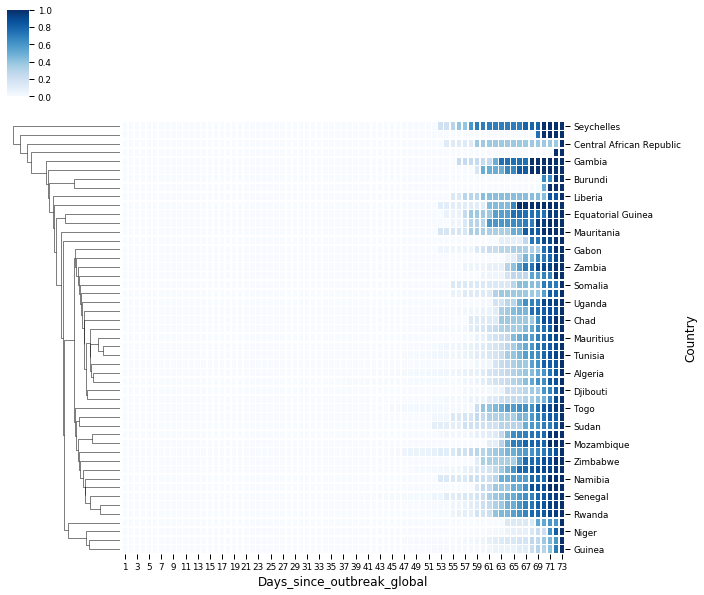

<Figure size 1800x576 with 0 Axes>

In [38]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Canada                     0.00 0.00 0.00 0.00 1.00 1.00 2.00 2.00 2.00 4.00   

Days_since_outbreak_global  ...      64      65      66      67      68  \
Country                     ...                                           
Antigua and Barbuda         ...    3.00    7.00    7.00    7.00    7.00   
Bahamas                     ...    5.00    9.00   10.00   10.00   11.00   
Barbados                    ...   18.00   18.00   24.00   26.00   33.00   
Belize                      ...    2.00    2.00    2.00    2.00 

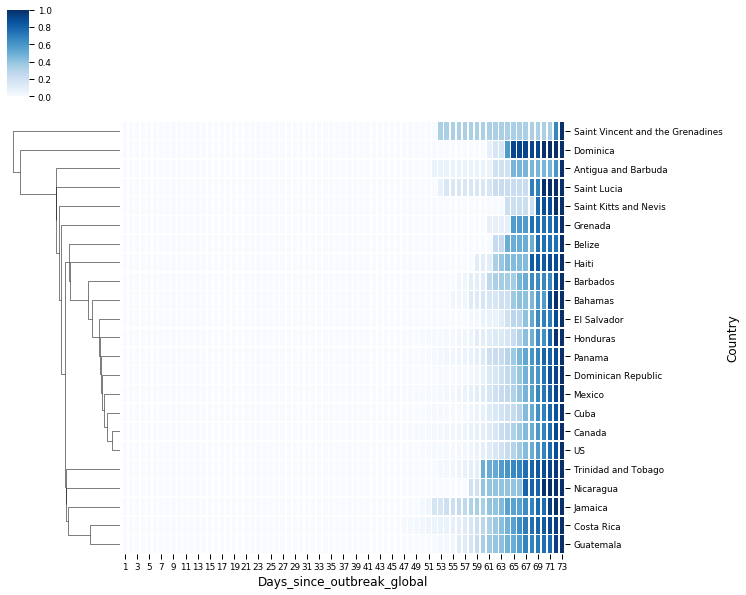

<Figure size 1800x576 with 0 Axes>

In [39]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Australia                  0.00 0.00 0.00 0.00 4.00 5.00 5.00 6.00 9.00 9.00   
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      64      65      66      67      68  \
Country                     ...                                           
Australia                   ... 2364.00 2810.00 3143.00 3640.00 3984.00   
Fiji                        ...    5.00    5.00    5.00    5.00    5.00   
New Zealand                 ...  205.00  283.00  368.00  451.00  514.00   
Papua New Guinea            ...    1.00    1.00    1.00    1.00    1.00   

Days_since_outbreak_global      69      70      71      72      73  

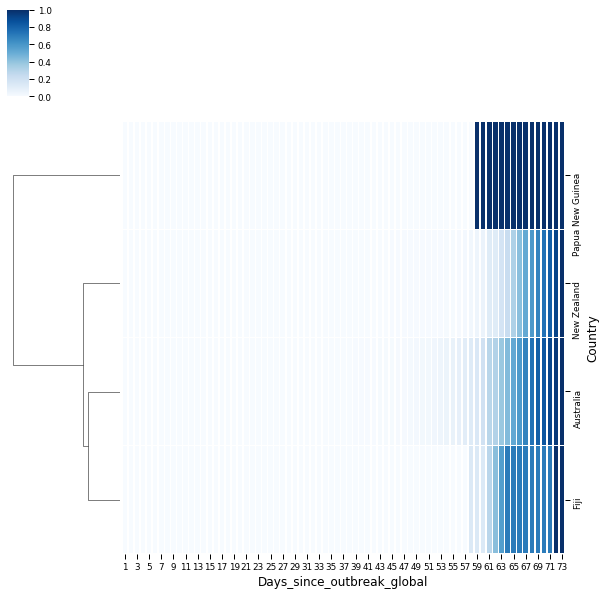

<Figure size 1800x576 with 0 Axes>

In [40]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      64      65      66      67      68  \
Country                     ...                                           
Argentina                   ...  387.00  502.00  589.00  690.00  745.00   
Bolivia                     ...   32.00   43.00   61.00   74.00   81.00   
Brazil                      ... 2554.00 2985.00 3417.00 3904.00 4256.00   
Chile                       ... 1142.00 1306.00 1610.00 1909.00 

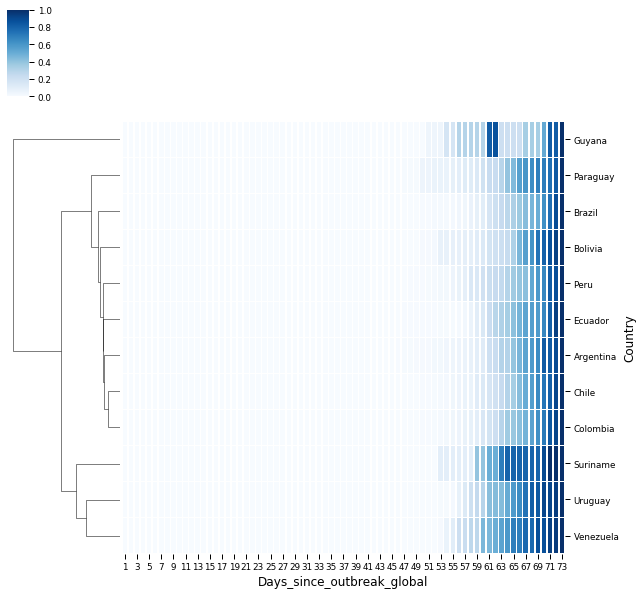

<Figure size 1800x576 with 0 Axes>

In [41]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [42]:
df['Date'] = df.index
df = df.reset_index(drop = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df['Deaths_lag_1'] = df.groupby('Province_and_country')['Deaths'].shift(1)
df['Daily_increase_death'] = (df['Deaths']/df['Deaths_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global,iso,...,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed,Deaths_lag_1,Daily_increase_death
0,Afghanistan,0,33.00,65.00,0.00,0.00,0.00,Afghanistan,1,AF,...,22,2,4,1,1,2020,0.00,0.00,0.00,0.00
1,Afghanistan,0,33.00,65.00,0.00,0.00,0.00,Afghanistan,2,AF,...,23,3,4,1,1,2020,0.00,0.00,0.00,0.00
2,Afghanistan,0,33.00,65.00,0.00,0.00,0.00,Afghanistan,3,AF,...,24,4,4,1,1,2020,0.00,0.00,0.00,0.00
3,Afghanistan,0,33.00,65.00,0.00,0.00,0.00,Afghanistan,4,AF,...,25,5,4,1,1,2020,0.00,0.00,0.00,0.00
4,Afghanistan,0,33.00,65.00,0.00,0.00,0.00,Afghanistan,5,AF,...,26,6,4,1,1,2020,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,Zimbabwe,0,-20.00,30.00,7.00,0.00,1.00,Zimbabwe,69,ZW,...,30,0,14,1,3,2020,7.00,0.00,1.00,0.00
18830,Zimbabwe,0,-20.00,30.00,8.00,0.00,1.00,Zimbabwe,70,ZW,...,31,1,14,1,3,2020,7.00,0.14,1.00,0.00
18831,Zimbabwe,0,-20.00,30.00,8.00,0.00,1.00,Zimbabwe,71,ZW,...,1,2,14,2,4,2020,8.00,0.00,1.00,0.00
18832,Zimbabwe,0,-20.00,30.00,9.00,0.00,1.00,Zimbabwe,72,ZW,...,2,3,14,2,4,2020,8.00,0.12,1.00,0.00


In [43]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Afghanistan                 ... 0.14 0.12 0.17 0.00 0.09 0.42 0.02 0.36 0.15   
Albania                     ... 0.19 0.19 0.07 0.06 0.08 0.05 0.09 0.07 0.07   
Algeria                     ... 0.14 0.22 0.11 0.11 0.13 0.14 0.23 0.18 0.16   
Andorra                     ... 0.15 0.

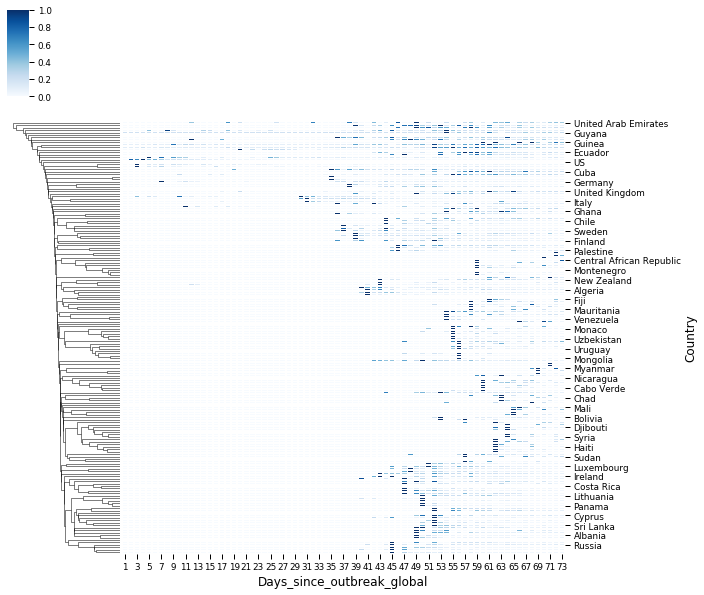

<Figure size 1800x576 with 0 Axes>

In [44]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2     3     4     5     6     7    8    9   \
Continent                                                                       
0                          0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00 0.00   
Africa                     0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00 0.00   
Asia                       0.00 32.88 31.62 39.51 19.95 20.03 15.68 7.48 9.05   
Diamond Princess           0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00 0.00   
Europe                     0.00  0.00  0.00  0.50  0.00  0.00  3.33 0.25 0.00   

Days_since_outbreak_global    10  ...    64    65    66   67    68   69   70  \
Continent                         ...                                          
0                           0.00  ...  0.00  0.00  0.00 0.00  0.00 0.00 0.00   
Africa                      0.00  ... 15.15  8.97  8.13 7.55 13.51 7.39 8.12   
Asia                       10.14  ...  9.87  6.12  6.17 5.00  5.84 3.98 3.91   
Diamond Princess            0.00

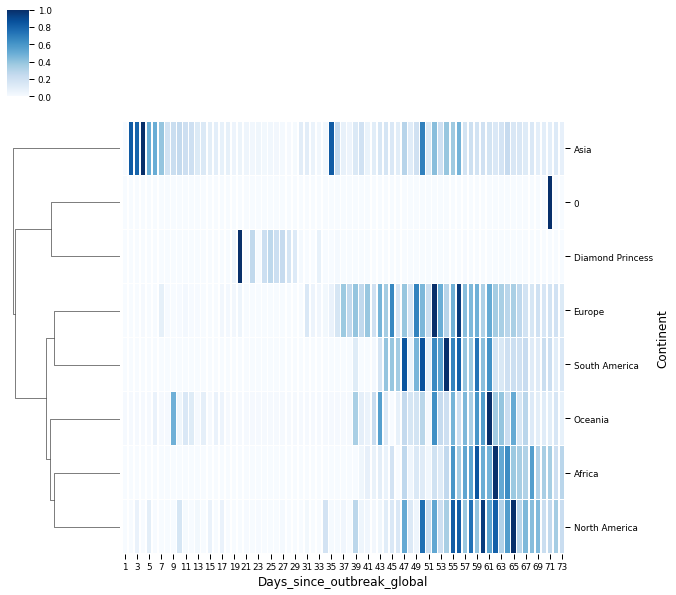

<Figure size 1800x576 with 0 Axes>

In [45]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Afghanistan                 ... 0.14 0.12 0.17 0.00 0.09 0.42 0.02 0.36 0.15   
Armenia                     ... 0.06 0.09 0.13 0.24 0.04 0.14 0.10 0.07 0.16   
Azerbaijan                  ... 0.07 0.31 0.35 0.10 0.15 0.31 0.09 0.20 0.11   
Bahrain                     ... 0.07 0.

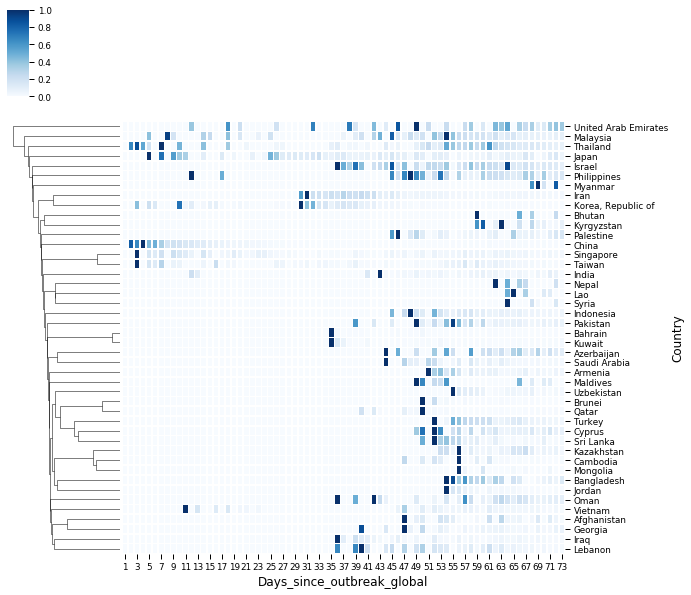

<Figure size 1800x576 with 0 Axes>

In [46]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Albania                     ... 0.19 0.19 0.07 0.06 0.08 0.05 0.09 0.07 0.07   
Andorra                     ... 0.15 0.19 0.19 0.15 0.08 0.11 0.02 0.04 0.10   
Austria                     ... 0.06 0.24 0.11 0.08 0.06 0.09 0.06 0.05 0.04   
Belarus                     ... 0.06 0.

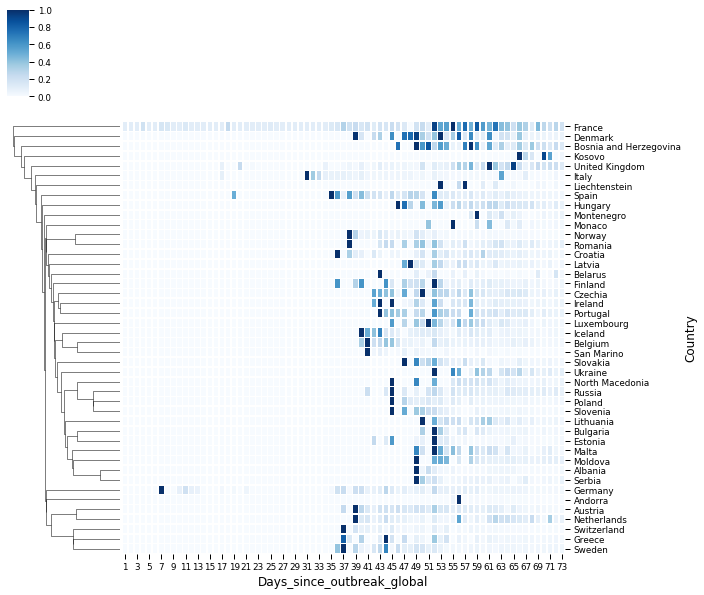

<Figure size 1800x576 with 0 Axes>

In [47]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Algeria                     ... 0.14 0.22 0.11 0.11 0.13 0.14 0.23 0.18 0.16   
Angola                      ... 0.00 0.33 0.00 0.25 0.40 0.00 0.00 0.14 0.00   
Benin                       ... 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.44 0.00   
Botswana                    ... 0.00 0.

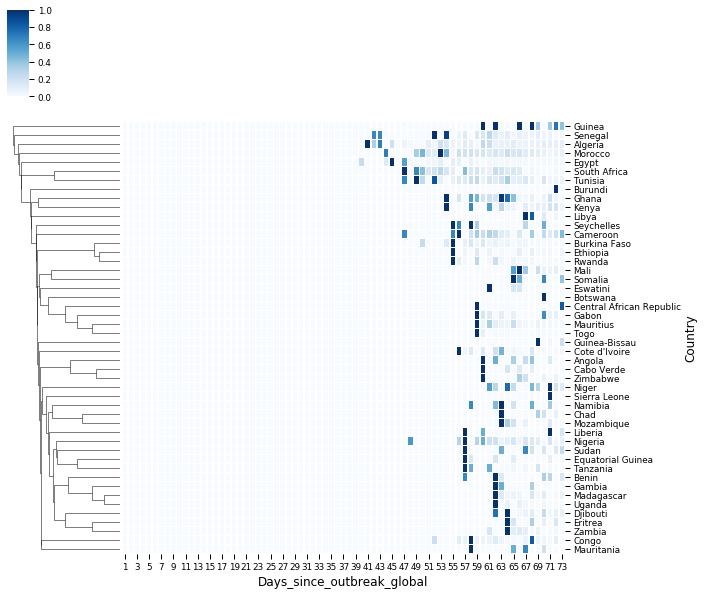

<Figure size 1800x576 with 0 Axes>

In [48]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Canada                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 2.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Antigua and Barbuda         ... 0.00 1.33 0.00 0.00 0.00 0.00 0.00 0.00 0.29   
Bahamas                     ... 0.00 0.80 0.11 0.00 0.10 0.27 0.00 0.50 0.14   
Barbados                    ... 0.00 0.00 0.33 0.08 0.27 0.00 0.03 0.00 0.35   
Belize                      ... 1.00 0.

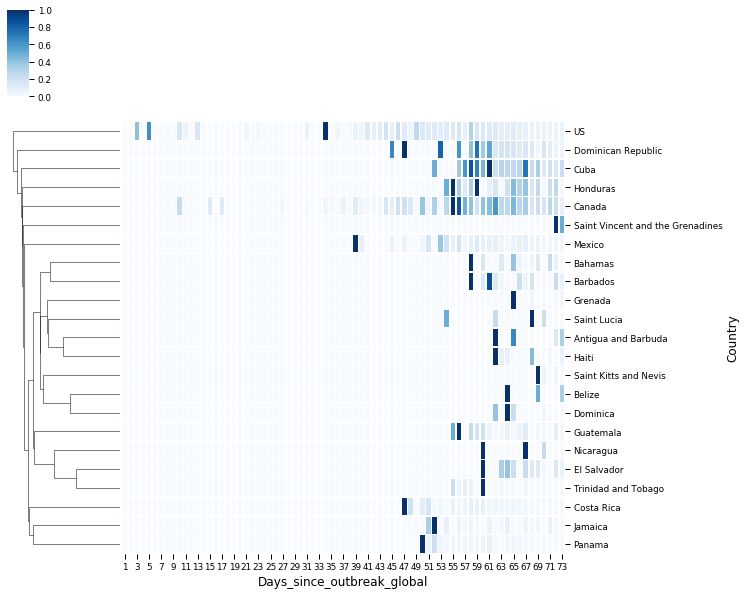

<Figure size 1800x576 with 0 Axes>

In [49]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Australia                  0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 3.00 0.17   
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Australia                   ... 0.79 2.78 0.65 1.50 0.59 0.43 0.53 0.51 0.40   
Fiji                        ... 0.25 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.40   
New Zealand                 ... 0.32 0.38 0.30 0.23 0.14 0.15 0.10 0.09 0.13   

Days_since_outbreak_global   73  
Country                          
Australia                  0.33  
Fiji                       0.00  
New Zealand                0.09  

[3 rows x 73 columns]


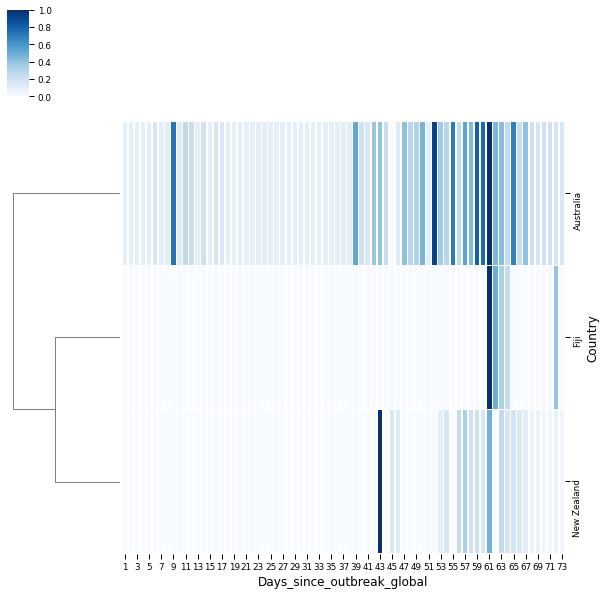

<Figure size 1800x576 with 0 Axes>

In [50]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   64   65   66   67   68   69   70   71   72  \
Country                     ...                                                
Argentina                   ... 0.00 0.30 0.17 0.17 0.08 0.10 0.29 0.00 0.07   
Bolivia                     ... 0.10 0.34 0.42 0.21 0.09 0.20 0.10 0.07 0.07   
Brazil                      ... 0.14 0.17 0.14 0.14 0.09 0.08 0.25 0.20 0.18   
Chile                       ... 0.24 0.

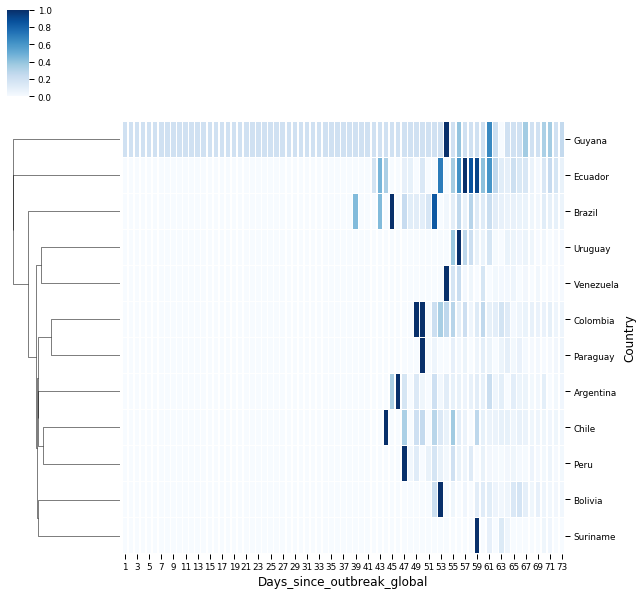

<Figure size 1800x576 with 0 Axes>

In [51]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction - preperation

In [55]:
#Confirmed
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [56]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [57]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 3, 27, 11, 11, 51, 272230)

In [58]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

22149.84318781023
148.82823383958512
1.9706793965860026


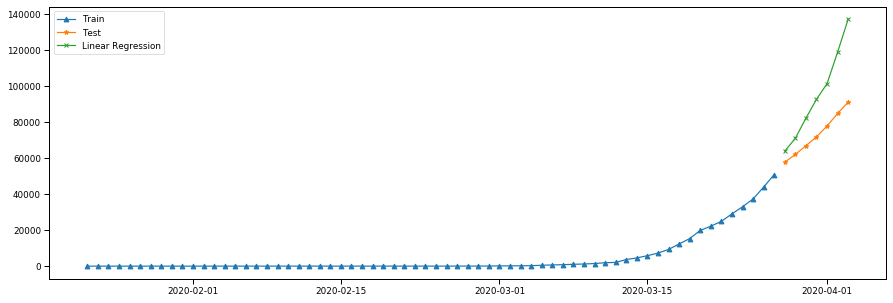

In [59]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

5522.847804766548
74.31586509465221
0.4913697260540134


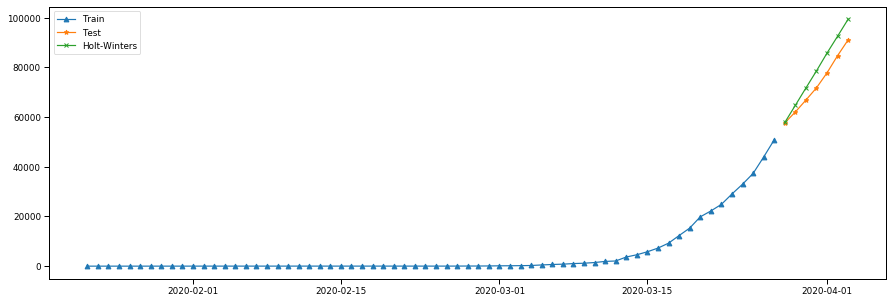

In [60]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

In [61]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [62]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
6592.969084330526
3
['add', True, 'add', 6, False, False]
6484.082677572819
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
6418.352102857329
11
['add', True, None, 6, False, False]
6306.878859265058
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
6591.641382392562
15
['add', False, 'add', 6, False, False]
6482.717804900058
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, False]

In [63]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [64]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

6306.878859265058 ['add', True, None, 6, False, False]
Mean Absolute Error: 5577.0
Mean Squared Error: 74044.898
Root Mean Squared Error: 6306.879
Mean absolute percentage error: 7.2
Scaled Mean absolute percentage error: 6.896
Mean forecast error: 79995.181
Normalised mean squared error: 0.27
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


5702.758337526089
75.51660967976575
0.5073764298998067


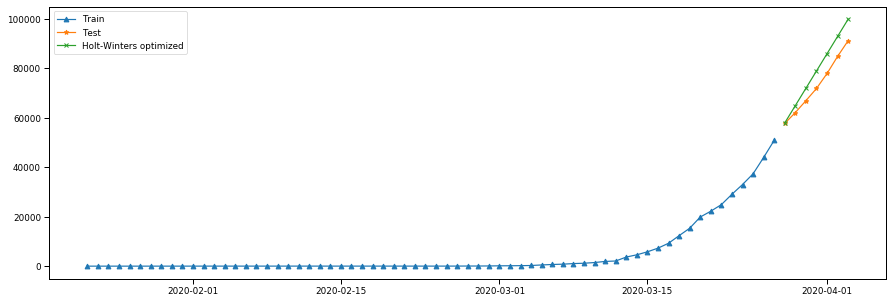

In [65]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=6, damped=True) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

#['add', True, None, 6, False, False]
# t1,d1,s1,p1,b1,r1

10571.32886510809
102.81696778794874
0.9405348747781791


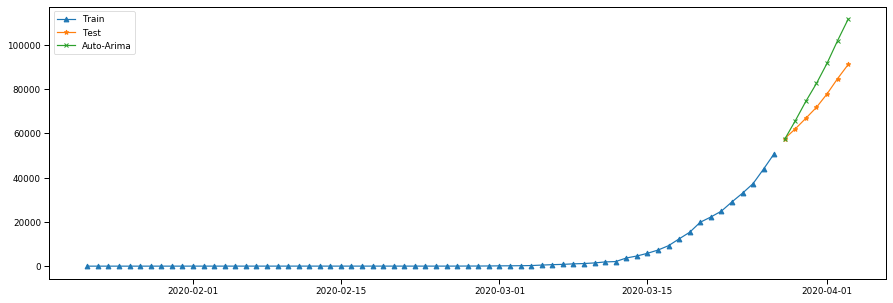

In [66]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

### All customers

In [67]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [76]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [78]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.SDMAE.notnull(), 'SDMAE']))

1547.927131282373
17.43159666570353
95.89493938290727


#### Holt-Winters (non-optimized)

In [79]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [80]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))

227.60959794822313
7.67019243235788
41.33896192430605


#### Holt-Winters (optimized)

In [81]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=6, damped=True) #Tuned_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [82]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.SDMAE.notnull(), 'SDMAE']))

76769.58526796616
276.16369418166033
29132.693150601073


#### Auto-ARIMA

In [83]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [84]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))

232.5355669709933
7.783695090423442
1.5772527337554028


In [85]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')